# Latent Semantic Analysis in Yelp Data

[Latent semantic analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis) (LSA) is a language processing technique that attempts to describe a corpus in [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) format using combination of concepts rather than a combination of terms. In LSA, terms that have a high co-occurrence across documents are assumed to be conceptually related. This relationship can be derived using [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) (SVD). By mapping a large number of terms to a smaller number of latent factors, the feature space is greatly reduced. Documents in this form require less storage space and can be clustered or compared more quickly. It also allows us to find relationships between documents that contain conceptually similar terms without actually containing the same terms.

In order to explore LSA, I decided to look at review data from the 5th round of the [Yelp Dataset Challenge](https://www.yelp.com/dataset_challenge).

## Libraries used
* JSON and Pandas for data handling
* Numpy for algebra
* Matplotlib abd Basemap for plotting
* Scikit learn for K means clustering, TF-IDF document vectorization, and SVD
* SciPy for eculidian distance calculation

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.spatial.distance import cdist
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 10)
pd.set_option('display.width', 800)

## Loading and cleaning the data
To start, we'll load the business-level data into a dataframe using Pandas' [JSON normalize](http://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.io.json.json_normalize.html) function. We'll also use the business id values as the dataframe index.

In [2]:
#normalize yelp business json
with open('../yelp_academic_dataset_business.json') as data_file:
    businesses=pd.io.json.json_normalize([json.loads(row) for row in data_file])

#set business id as the index
businesses.set_index('business_id',inplace=True)

The [Yelp Dataset webpage](https://www.yelp.com/dataset_challenge) lists 10 cities, including several where English isn't the primary language. To keep things simple, we're going to cut out any data from outside of the USA. Unfortunately, the data does not have a country field. Businesses have city values, but a quick summary shows that there are far more than 10 city names in the data.

In [3]:
businesses.city.describe()

count         61184
unique          378
top       Las Vegas
freq          13601
Name: city, dtype: object

Plotting the business coordinates using matplotlib and basemap reveals that the data comes from 10 metro areas. The 378 unique city values must come from suburb/neighborhood names.

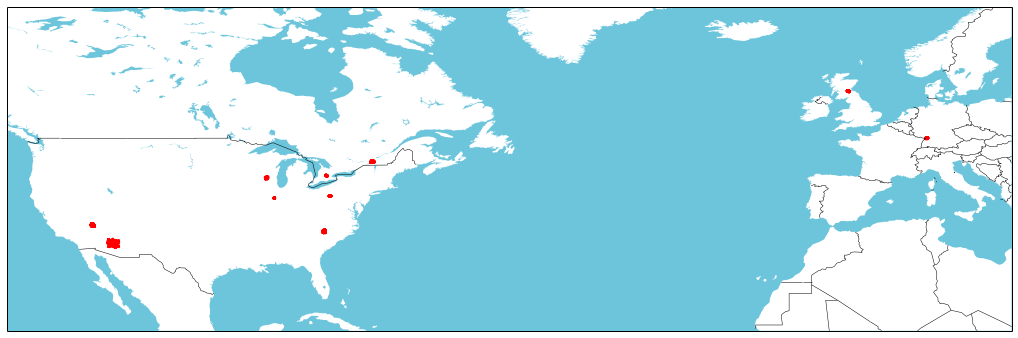

In [4]:
#Pul lat/lon from the businesses dataframe
coords=businesses[['latitude','longitude']].as_matrix()

#Set min/max coordinates for our basemap plot
lllon=coords[:,1].min()-coords[:,1].ptp()*.1
urlon=coords[:,1].max()+coords[:,1].ptp()*.1
lllat=coords[:,0].min()-coords[:,1].ptp()*.1
urlat=coords[:,0].max()+coords[:,1].ptp()*.1

#Create the basemap object using a map projection that somebody probably disagrees with
m = Basemap(projection='cyl',lon_0=0,llcrnrlon=lllon,urcrnrlon=urlon,llcrnrlat=lllat,urcrnrlat=urlat,resolution='l')
m.drawmapboundary(fill_color='#6DC5DC') # fill to edge
m.drawcountries()
m.fillcontinents(color='white',lake_color='#6DC5DC',zorder=0)

#plot the businesses as red dots
x,y=m(coords[:,1].tolist(),coords[:,0].tolist())
m.scatter(x,y,3,marker='o',color='r')
plt.show()

Because we know that we have distinct geographic clusters of businesses, we can use [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) to group them together. Even though we know there should be 10 clusters, we can generate a quick [elbow chart](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_Elbow_Method) to see how clustering performs at various values of k.

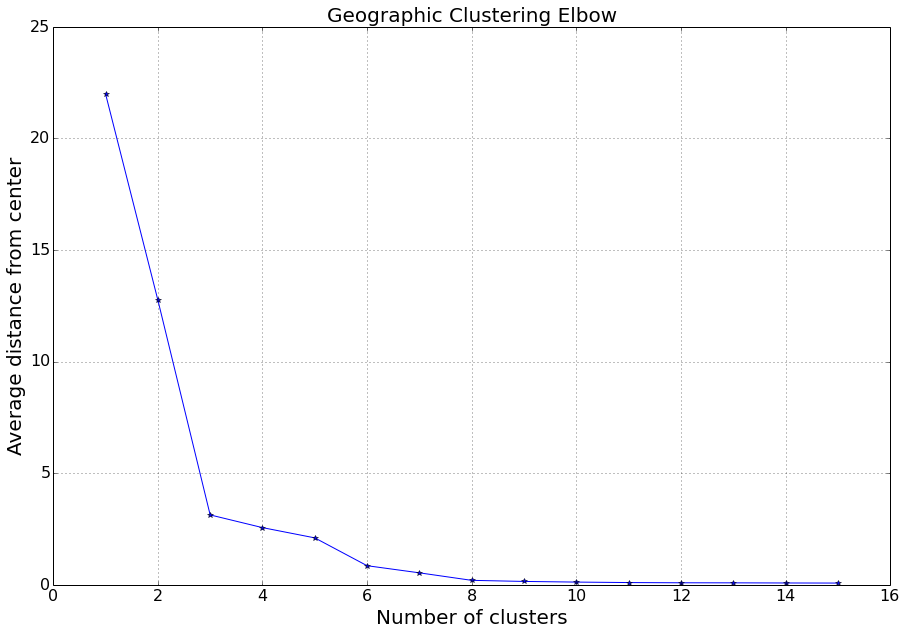

In [5]:
#specify the k values for a number of models, then generate and fit the models
cluster_sizes=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
geo_cluster_models=[KMeans(K, init='k-means++') for K in cluster_sizes]
for model in geo_cluster_models:
    model.fit(coords)

#for each model, calculate the average distance from each point to its cluster center
def avg_distance(model,inputs):
    predict=model.predict(inputs)
    centers=model.cluster_centers_
    distances=[]
    for i in enumerate(inputs):
        distances.append(np.linalg.norm(i[1]-centers[predict[i[0]]]))
    return np.mean(distances)

distances=[avg_distance(model,coords) for model in geo_cluster_models]

#Plot an elbow chart of the average distances
plt.rcParams['figure.figsize'] = (15, 10)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(cluster_sizes, distances, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters',fontsize=20)
plt.ylabel('Average distance from center',fontsize=20)
tt = plt.title('Geographic Clustering Elbow',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In our elbow chart, values of k above 3 make considerably less of a difference. This is because a large amount of lat/lon variation in our cities could be explained by grouping them into Southwest, Midwest/Canada, and European clusters. We happen to know that 10 clusters is ideal in our case, so we are still going to go with that value for k.

**Disclaimer:** K means clustering and euclidian distance are not ideal for most geospatial clustering problems. The approach we just used will not handle clusters that are near the [antimeridian](https://en.wikipedia.org/wiki/180th_meridian), and [Haversine distance](https://en.wikipedia.org/wiki/Haversine_formula) would be a better distance metric.

Now that we've got that disclaimer out of the way, we can create a new column that is populated by the most common city name in each cluster.

In [6]:
#Using k=10, predict a cluster value for each city and find the most common city name within each cluster
cluster=geo_cluster_models[9].predict(coords)
businesses['geo_cluster']=cluster
cluster_labels=businesses.groupby('geo_cluster')['city'].agg(lambda x:x.value_counts().index[0])

#Create a new cleaned_city column and populate it with our new city values
cluster_labels.name='cleaned_city'
businesses=pd.merge(businesses, pd.DataFrame(cluster_labels), how='left', left_on='geo_cluster', right_index=True,  copy=False)
businesses.cleaned_city.value_counts()

Phoenix       25231
Las Vegas     16490
Charlotte      5151
Montréal       3921
Edinburgh      3115
Pittsburgh     3041
Madison        2309
Karlsruhe       948
Champaign       627
Waterloo        351
dtype: int64

## Processing the review text

We will now load our text reviews, aggregate reviews at the business level, and throw away anything that isn't from the USA using the cleaned_city field.

In [7]:
#Load yelp review data
with open('../yelp_academic_dataset_review.json') as data_file:
    reviews=pd.io.json.json_normalize([json.loads(row) for row in data_file])

#Aggregate reviews into business-level documents
texts=reviews.groupby('business_id')['text'].apply(lambda x: ' '.join(x))

#Join reviews to cleaned city values and limit the table to the 6 US metro areas in the data
texts=texts.to_frame().merge(businesses.cleaned_city.to_frame(),left_index=True,right_index=True)
texts=texts[texts['cleaned_city'].isin(['Phoenix','Las Vegas','Charlotte','Pittsburgh','Madison','Champaign'])]

Every US business in our data set now has a single document that contains all of its Yelp reviews. To convert this into a bag of words, we'll use one of scikit learn's [vectorizer functions](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction.text). We'll be using the [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) vectorizer. This creates a row for every document and a column for every term. Each cell cell in this matrix contains a weighted value that represents the term's presence in the document relative to how common it is across all documents.

We'll include unigrams and bigrams (ngram_range), meaning one and two word [n-grams](https://en.wikipedia.org/wiki/N-gram). We'll also ignore [english stop words](https://en.wikipedia.org/wiki/Stop_words) and any terms that appear in fewer than 1% or more than 50% of our documents.

In [8]:
#Create the tf-idf vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words='english', min_df=.01, max_df=.5)

#Fit the model to our total vocabulary and store the transformed values for our reviews in the counts object
counts=vectorizer.fit_transform(texts.text.values)

#Save a list of the terms for later reference
terms=np.asarray(vectorizer.get_feature_names())

counts

<52819x15553 sparse matrix of type '<type 'numpy.float64'>'
	with 31629327 stored elements in Compressed Sparse Row format>

## Reducing our term features into concepts

The counts object is our set of reviews in bag-of-words form. It is a sparse object, which saves space, but it represents 52,819 documents and 15,553 terms. To reduce our terms into concepts, we will use the [TruncatedSVD function](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html). We'll specify that we want 50 concepts from our 15,553 terms.

In [9]:
#Generate the model and fit it to our counts object
lsa = TruncatedSVD(n_components=50, n_iter=10)
lsa.fit(counts)

TruncatedSVD(algorithm='randomized', n_components=50, n_iter=10,
       random_state=None, tol=0.0)

It can be difficult to distill what these factors mean. A factor cannot be summarized by the words that are most positively associated with it. All words, including those that are highly positive and highly negative, contribute to a factor.

To get a sense of what a factor can look like, we will pull the most positively/negatively associated terms and top 5 businesses for the first 5 factors.

**Note:** In this notebook, I will omit business names. Fortunately, yelp has category data. Most text data sets do not have this information at hand. With yelp data, we can use the category field to get a sense of what a business is without revealing the details.

In [10]:
#Pull the 4 words with the largest positive and negative contribution to a factor
def pull_top_factor_terms(factor):
    comp=lsa.components_[factor]
    termsInComp = zip (terms,comp)
    values=comp[comp.argsort()[::-1]]
    sortedTerms=terms[comp.argsort()[::-1]]
    pairs=zip(values,sortedTerms)
    print "Concept %d:" % factor
    for term in pairs[:4]+pairs[-4:]:
        print term

#Pull the 5 businesses that have the highest value for a given factor
def pull_top_factor_businesses(factor,count=5):
    return businesses.ix[texts.index[biz_factors[:,factor].argsort()[::-1][:count]]][['cleaned_city','categories']].to_string(index=False)

#Reduce our business data from 15,553 words to 50 factors
biz_factors=lsa.transform(counts)

#Print summaries for the first 5 factors
for i in range(5):
    pull_top_factor_terms(i)
    print pull_top_factor_businesses(i)
    print " "

Concept 0:
(0.36306222134665039, u'food')
(0.13246264349269168, u'chicken')
(0.1239897646730157, u'pizza')
(0.11622389379597485, u'restaurant')
(0.00046981503764521073, u'vegas know')
(0.00045390261451858354, u'day vegas')
(0.00044290612674361822, u'visiting las')
(0.00041971612215651184, u'vegas sure')
cleaned_city                                         categories
                                                               
   Las Vegas  [Food, Pizza, American (New), Breweries, Resta...
     Phoenix                             [British, Restaurants]
   Las Vegas  [Food, Breweries, American (New), Pizza, Resta...
   Las Vegas  [Food, Breweries, American (New), Pizza, Resta...
     Phoenix      [Pubs, Bars, Nightlife, British, Restaurants]
 
Concept 1:
(0.32031008841655001, u'food')
(0.14202567837759755, u'chicken')
(0.12732835369647616, u'pizza')
(0.10933543738465221, u'restaurant')
(-0.13994217824512215, u'hair')
(-0.15871356377351539, u'dr')
(-0.16579754726533869, u'car')
(-0.207

## Clustering businesses in the latent space

Our data has now been reduced to a 52,809x50 matrix, which is a lot easier to learn from. One application of this type of data would be k means clustering. We'll test this out by clustering with k equal to 1, 2, 4, 8, 16, 32, 64, 128, 256, and 512 to generate an elbow chart.

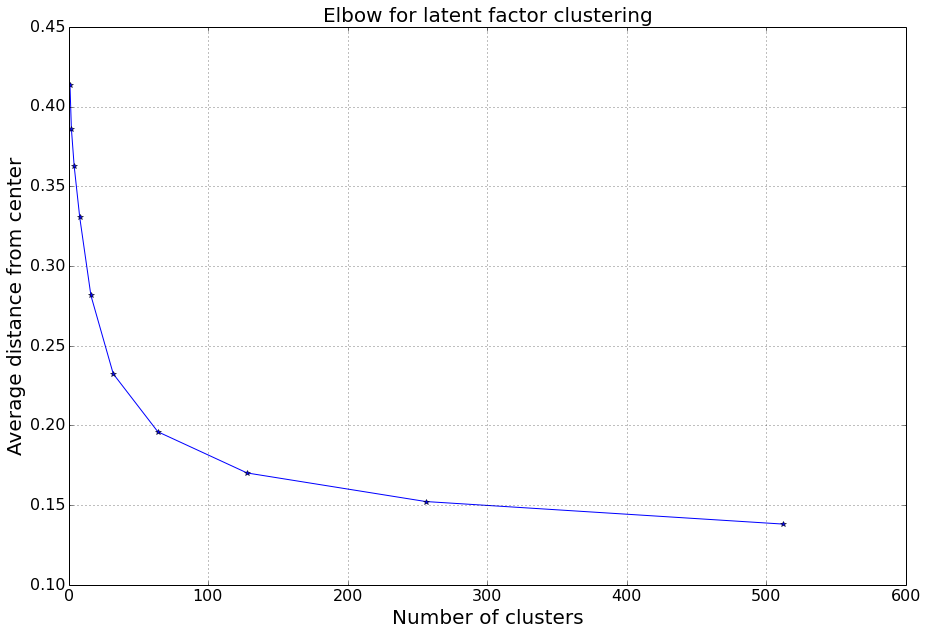

In [11]:
#Run k-means where k = 1, 2, 4, 8, 16, 32, 64, 128, 256, and 512
cluster_sizes=[2**i for i in range(10)]
biz_models=[KMeans(i, init='k-means++') for i in cluster_sizes]
for i in biz_models:
    i.fit(biz_factors)

    
#Measure the average distance from the cluster center for each value of k
scores=[avg_distance(model,biz_factors) for model in biz_models]

#plot the elbow chart
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(cluster_sizes, scores, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters',fontsize=20)
plt.ylabel('Average distance from center',fontsize=20)
tt = plt.title('Elbow for latent factor clustering',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Once we move beyond 64 clusters, we start to see less of a benefit. For that reason, we'll stick with 64 clusters. For each cluster, we will now pull the terms and businesses that are closest to the center. Once again, we won't show the specific details of the businesses.

In [12]:
#Choose the model where k=64, generate cluster predictions and the distance from each cluster center
model=biz_models[6]
clusters=model.predict(biz_factors)
distances=model.transform(biz_factors)

#Calculate each business' distance from the center of its cluster
biz_distance=[distances[biz[0],biz[1]] for biz in enumerate(clusters)]
texts['topic']=clusters
texts['topic_distance']=biz_distance

#Pull the terms closest to the cluster center
def pull_cluster_terms(cluster):
    center=model.cluster_centers_[cluster]
    print terms[lsa.inverse_transform(center)[0].argsort()[::-1]][:5]

#Pull the businesses closest to the clsuter center
def pull_cluster_businesses(cluster,count=5):
    members=texts[texts.topic==cluster]
    return businesses.ix[members.index[members.topic_distance.argsort()][:count]][['categories']]

#Pull the words and business descriptions that are closest to the cluster center
for i in range(5):
    print "Cluster: "+str(i)
    pull_cluster_terms(i)
    print " "
    print pull_cluster_businesses(i).to_string(index=False)
    print " "

Cluster: 0
[u'yogurt' u'toppings' u'flavors' u'frozen yogurt' u'frozen']
 
                                        categories
                                                  
                 [Food, Ice Cream & Frozen Yogurt]
 [Food, Ice Cream & Frozen Yogurt, Juice Bars &...
                 [Food, Ice Cream & Frozen Yogurt]
       [Food, Ice Cream & Frozen Yogurt, Desserts]
       [Food, Desserts, Ice Cream & Frozen Yogurt]
 
Cluster: 1
[u'food' u'restaurant' u'ordered' u'menu' u'salad']
 
                                        categories
                                                  
         [Breakfast & Brunch, Diners, Restaurants]
                     [American (New), Restaurants]
           [Nightlife, Seafood, Bars, Restaurants]
 [Food, Desserts, American (Traditional), Resta...
           [Nightlife, Seafood, Bars, Restaurants]
 
Cluster: 2
[u'store' u'told' u'customer' u'phone' u'company']
 
                                        categories
                           

## Retrieving businesses using input text
One of the advantages of mapping our business reviews into a lower dimensional latent space is that we can quickly compare businesses to each other or input text to all of our businesses. The latter is done by mapping input text into our latent space to identify which concepts are represented in the text. Once we have that information, we can find the businesses that are closest to our text in the latent space.

We still won't show any identifying information about the businesses, but you get the idea.

In [13]:
#Map text into the latent space and return the most similar businesses.
def businesses_from_text(text):
    t_counts=vectorizer.transform([text])
    t_factors=lsa.transform(t_counts)
    t_distances=cdist(t_factors,biz_factors)[0].argsort()
    best_matches=texts.index[t_distances][:10]
    return businesses.ix[best_matches][['categories']]

#Search for chinese food
print "Results for 'chinese food'"
print businesses_from_text('chinese food').to_string(index=False)
print " "

print "Results for 'worst chinese food'"
#Search for the worst chinese food
print businesses_from_text('worst chinese food').to_string(index=False)
print " "

print "Results for 'thai sushi'"
#Search for the worst chinese food
print businesses_from_text('thai sushi').to_string(index=False)
print " "

print "Results for 'skin doctor'"
#Search for a "skin doctor"
print businesses_from_text('skin doctor').to_string(index=False)
print " "

print "Results for 'dog doctor'"
#Search for a "dog doctor"
print businesses_from_text('dog doctor').to_string(index=False)
print " "

Results for 'chinese food'
             categories
                       
 [Chinese, Restaurants]
 [Chinese, Restaurants]
 [Chinese, Restaurants]
          [Restaurants]
 [Chinese, Restaurants]
 [Chinese, Restaurants]
 [Chinese, Restaurants]
 [Chinese, Restaurants]
 [Chinese, Restaurants]
 [Chinese, Restaurants]
 
Results for 'worst chinese food'
             categories
                       
 [Chinese, Restaurants]
 [Chinese, Restaurants]
 [Chinese, Restaurants]
 [Chinese, Restaurants]
          [Restaurants]
 [Chinese, Restaurants]
 [Chinese, Restaurants]
          [Restaurants]
 [Chinese, Restaurants]
 [Chinese, Restaurants]
 
Results for 'thai sushi'
                                    categories
                                              
               [Thai, Sushi Bars, Restaurants]
     [Thai, Sushi Bars, Japanese, Restaurants]
 [Thai, Sushi Bars, Asian Fusion, Restaurants]
           [Sushi Bars, Japanese, Restaurants]
                   [Asian Fusion, Restaurants]
      

By mapping our text into a latent space, we were able to very quickly retrieve results that were relevant to an input query. We were also able to type in vague phrases like 'skin doctor' and 'dog doctor,' identify the concept that those words represent, and retrieve relevant results represent the same concepts.
## Conclusion
LSA is a powerful method of principal component analysis that can be used to identify concempts and compress data. Mapping data into a smaller number of dimensions can significantly improve performance and fitting time on clustering algorithms and predictive models. Hopefully you learned as much from this code as I learned from writing it!

http://dataneel.com